In [262]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Exploration de données

In [263]:
data = pd.read_parquet(Path("data") / "train.parquet")
data['log_bike_count'] = np.log(1 + data['bike_count'])

data=data.drop(
    columns=[
        "site_id",
        "counter_id",
        "coordinates",
        "counter_technical_id",
        "counter_installation_date",
        #"latitude",
        #"longitude",
        
    ]
)


## Counters activity

In [255]:
date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')
all_counters = pd.Categorical(data['counter_name'].unique())
all_combinations = pd.MultiIndex.from_product([date_range, all_counters], names=['date', 'counter_name'])
expected_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge the original DataFrame with the expected DataFrame
merged_df = pd.merge(expected_df, data, how='left', on=['date', 'counter_name'])

# Create a binary variable indicating if the counter is active (1) or inactive (0)
merged_df['activity'] = merged_df['counter_name'].notnull().astype(int)

# Drop unnecessary columns
#merged_df = merged_df.drop(columns=['your_original_columns'])

# Now, merged_df contains the information you need
data = merged_df
data


,date,counter_name,site_name,bike_count,log_bike_count,activity,hour,is_weekend,Holiday,Season
0,2020-09-01 01:00:00,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,1,1,False,0,4.0
1,2020-09-01 01:00:00,28 boulevard Diderot O-E,28 boulevard Diderot,1.0,0.693147,1,1,False,0,4.0
2,2020-09-01 01:00:00,39 quai François Mauriac NO-SE,39 quai François Mauriac,2.0,1.098612,1,1,False,0,4.0
3,2020-09-01 01:00:00,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,1,1,False,0,4.0
4,2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,1,1,False,0,4.0
...,...,...,...,...,...,...,...,...,...,...
502595,2021-09-09 23:00:00,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,1,23,False,0,4.0
502596,2021-09-09 23:00:00,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,1,23,False,0,4.0
502597,2021-09-09 23:00:00,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,1,23,False,0,4.0
502598,2021-09-09 23:00:00,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,1,23,False,0,4.0


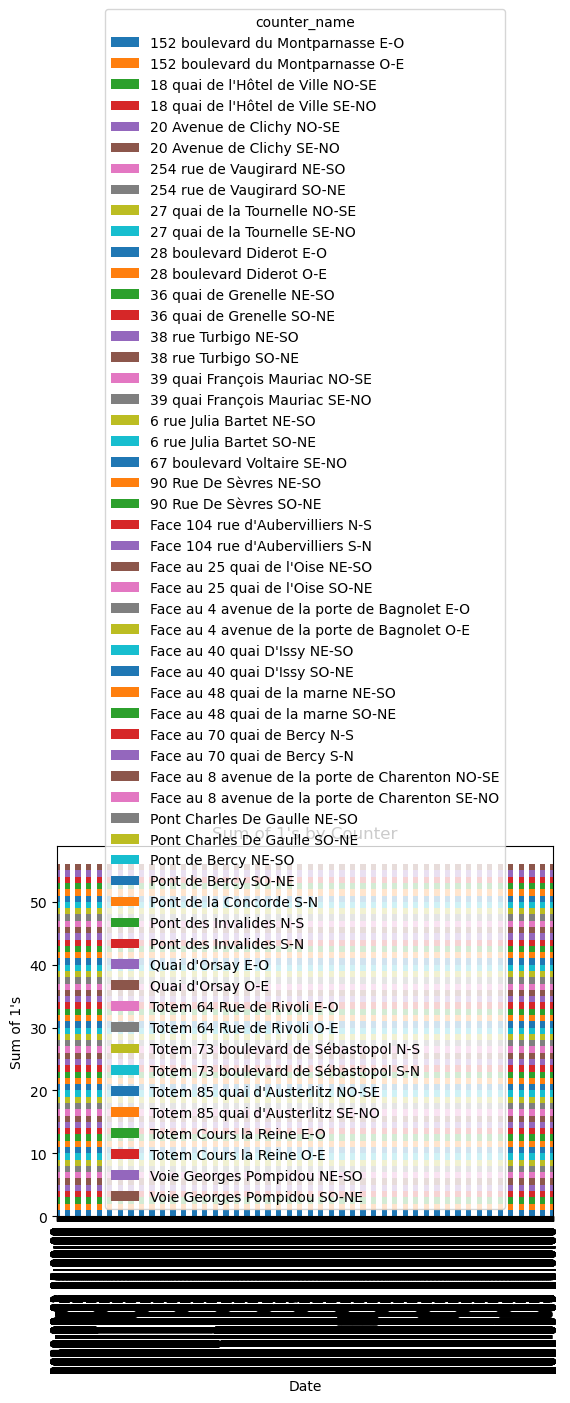

In [258]:
grouped_df = data.groupby(['date', 'counter_name'])['activity'].sum().reset_index()

# Pivot the DataFrame to have 'counter_name' as columns
pivot_df = grouped_df.pivot(index='date', columns='counter_name', values='activity').fillna(0)

# Plot the bar chart
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sum of 1\'s by Counter')
plt.xlabel('Date')
plt.ylabel('Sum of 1\'s')
plt.show()


In [155]:
def add_activity_column(data, y):
    # Assuming 'date' column is of datetime type and 'counter_name' is categorical
    # If not, convert them using:
    # data['date'] = pd.to_datetime(data['date'])
    # data['counter_name'] = pd.Categorical(data['counter_name'])

    # Create a DataFrame with all possible combinations of dates and counters
    date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')
    all_counters = pd.Categorical(data['counter_name'].unique())
    all_combinations = pd.MultiIndex.from_product([date_range, all_counters], names=['date', 'counter_name'])
    expected_df = pd.DataFrame(index=all_combinations).reset_index()

    # Merge the original DataFrame with the expected DataFrame
    merged_df = pd.merge(expected_df, data, how='left', on=['date', 'counter_name'])

    # Create a binary variable indicating if the counter is active (1) or inactive (0)
    merged_df['activity'] = merged_df['counter_name'].notnull().astype(int)

    y_ = merged_df['activity'].values.copy()

    # Replace values equal to 1 with the values from y
    y_[y_ == 1] = y[:np.sum(y_ == 1)]  # Assuming y has enough values for all 1s in 'activity'

    data=merged_df
    y=y_
    return data, y


In [230]:
import pandas as pd

def activity(X, y):
    # Step 1
    all_dates = pd.date_range(start=min(X['date']), end=max(X['date']), freq='H')
    all_counters = X['counter_name'].unique()

    all_combinations = pd.MultiIndex.from_product([all_dates, all_counters], names=['date', 'counter_name'])
    existing_combinations = pd.MultiIndex.from_frame(X[['date', 'counter_name']])

    missing_combinations = all_combinations.difference(existing_combinations)

    # Step 2
    template_df = pd.DataFrame(index=missing_combinations).reset_index()

    # Step 3
    merged_df = pd.merge(template_df, X, on=['date', 'counter_name'], how='left')
    merged_df['activity'] = merged_df['counter_name'].apply(lambda x: 1 if pd.notna(x) else 0)

    # Step 4
    y_template = pd.DataFrame(index=missing_combinations).reset_index()
    y_template['target'] = 0

    # Ensure the same order of rows in X and y
    X_final = pd.concat([X, merged_df[['date', 'counter_name', 'activity']]]).reset_index(drop=True)
    
    # Ensure y_final is a DataFrame
    #y_final = pd.concat([pd.DataFrame(y), y_template[['target']]]).reset_index(drop=True)
    #y_final = pd.concat([pd.DataFrame(y), y_template[['target']]], axis=1).sum(axis=1).reset_index(drop=True)
    y_final = pd.concat([pd.DataFrame(y), y_template[['target']]]).reset_index(drop=True)
    

    y_final.iloc[:,1] = y_final.iloc[:,0].combine_first(y_final.iloc[:,1])
    y_final = y_final.drop(y_final.columns[0], axis = 1)



    return X_final, y_final

## Test sur date

In [53]:
data['hour'] = data['date'].dt.hour

# Group by the hour and count the data points
hourly_counts = data.groupby('hour').size().reset_index(name='count')

# Display the result
print(hourly_counts)

    hour  count
0      0  20888
1      1  20944
2      2  20944
3      3  20944
4      4  20944
5      5  20944
6      6  20944
7      7  20944
8      8  20944
9      9  20944
10    10  20944
11    11  20944
12    12  20944
13    13  20944
14    14  20944
15    15  20944
16    16  20944
17    17  20944
18    18  20944
19    19  20944
20    20  20944
21    21  20944
22    22  20944
23    23  20944


## Rain (bonne implémentation dans linear model)

In [54]:
data2 = pd.read_csv(Path("data") / 'external_data.csv')
data2['date']=pd.to_datetime(data2['date'])
data2 = data2.drop_duplicates()
rain = data2[['date','rr3']]
rain['rr3']= rain['rr3']*(1/3)#rr3 indique le total de la pluie tombée les 3 dernières heures

/var/folders/6m/4wjzvmz96lv4n94v4gkvf__00000gn/T/ipykernel_83429/975842455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain['rr3']= rain['rr3']*(1/3)#rr3 indique le total de la pluie tombée les 3 dernières heures


In [55]:
rain = pd.merge(data,rain,on='date',how='left')
rain

,date,counter_name,site_name,bike_count,log_bike_count,activity,hour,rr3
0,2020-09-01 01:00:00,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,1,1,NaN
1,2020-09-01 01:00:00,28 boulevard Diderot O-E,28 boulevard Diderot,1.0,0.693147,1,1,NaN
2,2020-09-01 01:00:00,39 quai François Mauriac NO-SE,39 quai François Mauriac,2.0,1.098612,1,1,NaN
3,2020-09-01 01:00:00,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,1,1,NaN
4,2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,1,1,NaN
...,...,...,...,...,...,...,...,...
502595,2021-09-09 23:00:00,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,1,23,NaN
502596,2021-09-09 23:00:00,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,1,23,NaN
502597,2021-09-09 23:00:00,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,1,23,NaN
502598,2021-09-09 23:00:00,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,1,23,NaN


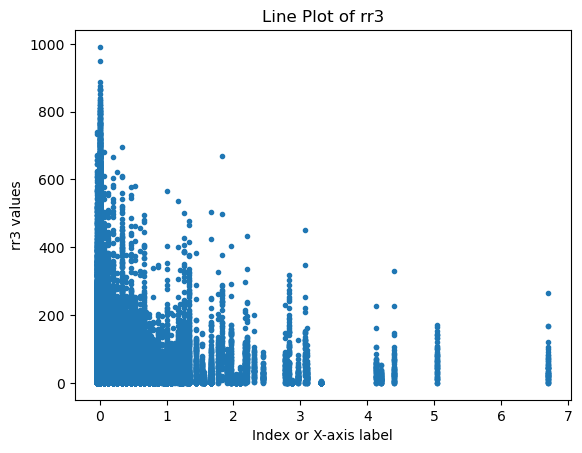

In [56]:
import matplotlib.pyplot as plt

# Assuming 'rain' is your DataFrame and 'rr3' is the column you want to plot
plt.plot(rain['rr3'],rain['bike_count'],'.')

# Adding labels and title
plt.xlabel('Index or X-axis label')
plt.ylabel('rr3 values')
plt.title('Line Plot of rr3')

# Display the plot
plt.show()


In [57]:
rain['log_rain'] = np.log(1 + rain['rr3_x'])
plt.plot(rain['log_rain'],rain['bike_count_x'],'.')

KeyError: 'rr3_x'

In [ ]:
merged_df = pd.merge(data, rain, on='date', how='left')
merged_df['rr3']=merged_df['rr3'].interpolate(method = 'bfill')
data=merged_df
#data.nunique()
data

,counter_name_x,site_name_x,bike_count_x,date,log_bike_count_x,hour_x,counter_name_y,site_name_y,bike_count_y,log_bike_count_y,hour_y,rr3
0,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,0.000000,2,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,2,0.0
1,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,0.000000,2,28 boulevard Diderot O-E,28 boulevard Diderot,2.0,1.098612,2,0.0
2,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,0.000000,2,39 quai François Mauriac NO-SE,39 quai François Mauriac,5.0,1.791759,2,0.0
3,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,0.000000,2,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,2,0.0
4,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,0.000000,2,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27513592,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2.772589,23,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,23,NaN
27513593,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2.772589,23,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,23,NaN
27513594,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2.772589,23,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,23,NaN
27513595,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2.772589,23,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,23,NaN


## Temperature

In [ ]:
temperature = data2[['date','tn12']]
#temperature.nunique()
#temperature['month'] = temperature['date'].dt.month
#temperature.groupby(['month'])['tn12'].nunique()

In [ ]:
temperature = pd.merge(data, temperature, on = 'date', how = 'left')

In [ ]:
plt.plot(temperature['tn12']**(1/2)+ temperature['tn12']**(1/3),temperature['bike_count'],'.')

# Adding labels and title
plt.xlabel('Index or X-axis label')
plt.ylabel('rr3 values')
plt.title('Line Plot of rr3')

# Display the plot
plt.show()


NameError: name 'temperature' is not defined

## Trucs du prof


In [58]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [59]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
0,2020,9,1,1,1
1,2020,9,1,1,1
2,2020,9,1,1,1
3,2020,9,1,1,1
4,2020,9,1,1,1


In [60]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Weekend

In [61]:
data["is_weekend"]=data["date"].dt.dayofweek.isin([5, 6])
data

,date,counter_name,site_name,bike_count,log_bike_count,activity,hour,is_weekend
0,2020-09-01 01:00:00,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,1,1,False
1,2020-09-01 01:00:00,28 boulevard Diderot O-E,28 boulevard Diderot,1.0,0.693147,1,1,False
2,2020-09-01 01:00:00,39 quai François Mauriac NO-SE,39 quai François Mauriac,2.0,1.098612,1,1,False
3,2020-09-01 01:00:00,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,1,1,False
4,2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,1,1,False
...,...,...,...,...,...,...,...,...
502595,2021-09-09 23:00:00,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,1,23,False
502596,2021-09-09 23:00:00,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,1,23,False
502597,2021-09-09 23:00:00,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,1,23,False
502598,2021-09-09 23:00:00,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,1,23,False


## Time of the day

In [62]:
def get_TimeOfDay(hour):
  if hour > 3 and hour <= 6:
    return 1  
  if hour > 6 and hour <= 10:
    return 2
  elif hour > 10 and hour <= 13:
    return 3
  elif hour > 13 and hour <= 17:
    return 4
  elif hour > 17 and hour <= 22:
    return 5
  else :
    return 6

## Holidays

In [63]:
import holidays
holidays = holidays.CountryHoliday('France')

# Function to check if a date is a holiday
def is_holiday(date):
    return 1 if date in holidays else 0

# Add a "Holiday" column to the DataFrame
data['Holiday'] = data['date'].apply(is_holiday)
data


,date,counter_name,site_name,bike_count,log_bike_count,activity,hour,is_weekend,Holiday
0,2020-09-01 01:00:00,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,1,1,False,0
1,2020-09-01 01:00:00,28 boulevard Diderot O-E,28 boulevard Diderot,1.0,0.693147,1,1,False,0
2,2020-09-01 01:00:00,39 quai François Mauriac NO-SE,39 quai François Mauriac,2.0,1.098612,1,1,False,0
3,2020-09-01 01:00:00,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,1,1,False,0
4,2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,1,1,False,0
...,...,...,...,...,...,...,...,...,...
502595,2021-09-09 23:00:00,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,1,23,False,0
502596,2021-09-09 23:00:00,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,1,23,False,0
502597,2021-09-09 23:00:00,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,1,23,False,0
502598,2021-09-09 23:00:00,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,1,23,False,0


## Season

In [64]:
from datetime import datetime
def get_season(date):
    if (date.month >= 1 and date.month < 3) or (date.month == 12 and date.day >= 21):
        return 1  # Winter
    elif date.month >= 3 and date.month < 6:
        return 2  # Spring
    elif date.month >= 6 and date.month < 9:
        return 3  # Summer
    elif date.month >= 9 and date.month < 12:
        return 4  # Autumn

In [65]:
data['Season'] = data['date'].apply(get_season)
data

,date,counter_name,site_name,bike_count,log_bike_count,activity,hour,is_weekend,Holiday,Season
0,2020-09-01 01:00:00,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,0.000000,1,1,False,0,4.0
1,2020-09-01 01:00:00,28 boulevard Diderot O-E,28 boulevard Diderot,1.0,0.693147,1,1,False,0,4.0
2,2020-09-01 01:00:00,39 quai François Mauriac NO-SE,39 quai François Mauriac,2.0,1.098612,1,1,False,0,4.0
3,2020-09-01 01:00:00,39 quai François Mauriac SE-NO,39 quai François Mauriac,1.0,0.693147,1,1,False,0,4.0
4,2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,0.0,0.000000,1,1,False,0,4.0
...,...,...,...,...,...,...,...,...,...,...
502595,2021-09-09 23:00:00,90 Rue De Sèvres SO-NE,90 Rue De Sèvres,43.0,3.784190,1,23,False,0,4.0
502596,2021-09-09 23:00:00,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,88.0,4.488636,1,23,False,0,4.0
502597,2021-09-09 23:00:00,20 Avenue de Clichy SE-NO,20 Avenue de Clichy,21.0,3.091042,1,23,False,0,4.0
502598,2021-09-09 23:00:00,254 rue de Vaugirard NE-SO,254 rue de Vaugirard,40.0,3.713572,1,23,False,0,4.0


## Couvre-feux


In [66]:

def encode_couvre_feu(row):
    hour = row['date'].hour

    if (
        (pd.to_datetime('2020-10-17') < row['date'] < pd.to_datetime('2020-10-29')) or
        (pd.to_datetime('2021-05-19') < row['date'] < pd.to_datetime('2021-06-08'))
    ):
        return 1 if 23 <= hour < 6 else 0  # Couvre-feu 23h-6h
    elif (
        (pd.to_datetime('2020-12-15') < row['date'] < pd.to_datetime('2021-01-15'))
    ):
        return 1 if 20 <= hour < 6 else 0  # Couvre-feu 20h-6h
    elif (
        (pd.to_datetime('2020-01-16') < row['date'] < pd.to_datetime('2021-03-19'))
    ):
        return 1 if 18 <= hour < 6 else 0  # Couvre-feu 18h-6h
    elif (
        (pd.to_datetime('2020-03-20') < row['date'] < pd.to_datetime('2021-05-18'))
    ):
        return 1 if 19 <= hour < 6 else 0  # Couvre-feu 19h-6h
    elif (
        (pd.to_datetime('2021-06-09') < row['date'] < pd.to_datetime('2021-06-20'))
    ):
        return 1 if 23 <= hour < 6 else 0  # Couvre-feu 23h-6h
    else:
        return 0  # Pas de couvre-feu



In [67]:
def encode_couvre_feu2(row):
    hour = row['date'].hour
    
    date_ranges = [
        (pd.to_datetime('2020-10-17'), pd.to_datetime('2020-10-29')),
        (pd.to_datetime('2021-05-19'), pd.to_datetime('2021-06-08')),
        (pd.to_datetime('2020-12-15'), pd.to_datetime('2021-01-15')),
        (pd.to_datetime('2020-01-16'), pd.to_datetime('2021-03-19')),
        (pd.to_datetime('2020-03-20'), pd.to_datetime('2021-05-18')),
        (pd.to_datetime('2021-06-09'), pd.to_datetime('2021-06-20'))
    ]
    
    for start_date, end_date in date_ranges:
        if start_date <= row['date'] < end_date:
            if (start_date, end_date) in [(pd.to_datetime('2020-10-17'), pd.to_datetime('2020-10-29')),
                                          (pd.to_datetime('2021-06-09'), pd.to_datetime('2021-06-20'))]:
                return 1 if 23 <= hour < 6 else 0  # Couvre-feu 23h-6h
            elif start_date == pd.to_datetime('2020-12-15'):
                return 1 if 20 <= hour < 6 else 0  # Couvre-feu 20h-6h
            elif start_date == pd.to_datetime('2020-01-16'):
                return 1 if 18 <= hour < 6 else 0  # Couvre-feu 18h-6h
            elif start_date == pd.to_datetime('2020-03-20'):
                return 1 if 19 <= hour < 6 else 0  # Couvre-feu 19h-6h
    return 0  #

## Distance du centre

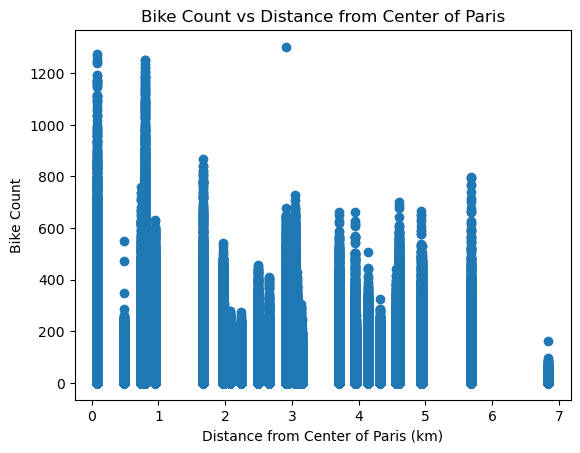

In [265]:
data['distance'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), paris_center).km, axis=1)

# Plot bike count against distances
plt.scatter(data['distance'], data['bike_count'])
plt.xlabel('Distance from Center of Paris (km)')
plt.ylabel('Bike Count')
plt.title('Bike Count vs Distance from Center of Paris')
plt.show()

In [268]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
paris_center = (48.8566, 2.3522)  # Coordinates of the center of Paris

def classify_distance(row):
    distance = geodesic((row['latitude'], row['longitude']), paris_center).km

    if distance < 2:  # Adjust this threshold based on your criteria
        return 1  # Center
    elif distance < 6:
        return 2  # Intermediate
    else:
        return 3  # Peripheral



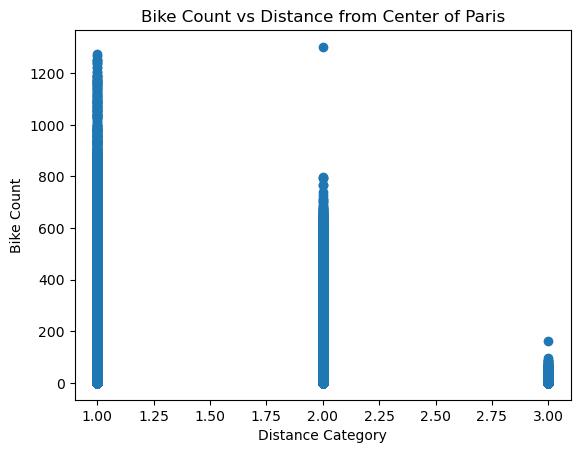

In [267]:
data['distance_category'] = data.apply(classify_distance, axis=1)

# Plot the bike count with respect to the distance from the center
plt.scatter(data['distance_category'], data['bike_count'])
plt.xlabel('Distance Category')
plt.ylabel('Bike Count')
plt.title('Bike Count vs Distance from Center of Paris')
plt.show()

# Linear model

In [273]:
import utils

X, y = utils.get_train_data()
X.head(2)
#X,y = activity(X, y)


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


In [274]:
X

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660
...,...,...,...,...,...,...,...,...,...,...
792857,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-09-09 23:00:00,2020-02-18,"48.84201,2.36729",YTH19111508,48.842010,2.367290
805182,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440
815218,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-09-09 23:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440
125979,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-09-09 23:00:00,2017-12-15,"48.8484,2.27586",Y2H21025335,48.848400,2.275860


In [275]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

In [276]:
#data2 = pd.read_csv(Path("data") / 'external_data.csv')
#data2['date']=pd.to_datetime(data2['date'])
#data2 = data2.drop_duplicates()
#Rain feature
#rain = data2[['date','rr3']]
#rain['rr3']= rain['rr3']*(1/3)
#Weekend feature
X['date'] = pd.to_datetime(X['date'])

X=X.drop(
    columns=[
        "site_id",
        "counter_id",
        "coordinates",
        "counter_technical_id",
        "counter_installation_date",
        #"latitude",
        #"longitude"
    ]
)
#X['TimeOfDay'] = X['date'].dt.hour.apply(get_TimeOfDay)
X["is_weekend"]=X["date"].dt.dayofweek.isin([5, 6])
X['is_holiday'] = X['date'].apply(is_holiday)
X['season'] = X['date'].apply(get_season)
X['is_confinement'] = (X["date"] > '2020-03-17') & (X["date"] < '2020-05-11') | (X["date"] > '2020-10-30') & (X["date"] < '2020-12-15')| (X["date"] > '2021-04-03') & (X["date"] < '2021-05-03')
#X["is_couvre_feu"] = X.apply(encode_couvre_feu2, axis=1)
X['distance'] = X.apply(classify_distance, axis=1)

#X["couvre-feu 21h-6h"] = (X["date"]> '2020-10-17')& (X["date"] < '2020-10-29')| (X["date"] > '2021-05-19') & (X["date"] < '2021-06-08')
#X["couvre-feu 20h-6h"] = (X["date"]> '2020-12-15')& (X["date"] < '2021-01-15')
#X["couvre-feu 18h-6h"] = (X["date"]> '2020-01-16')& (X["date"] < '2021-03-19')
#X["couvre-feu 19h-6h"] = (X["date"]> '2020-03-20')& (X["date"] < '2021-05-18')
#X["couvre-feu 23h-6h"]= (X["date"] > '2021-06-09') & (X["date"] < '2021-06-20')

In [277]:
X['TimeOfDay'] = X['date'].dt.hour.apply(get_TimeOfDay)
X

,counter_name,site_name,date,latitude,longitude,is_weekend,is_holiday,season,is_confinement,distance,TimeOfDay
400125,152 boulevard du Montparnasse E-O,152 boulevard du Montparnasse,2020-09-01 01:00:00,48.840801,2.333233,False,0,4.0,False,2,6
408305,152 boulevard du Montparnasse O-E,152 boulevard du Montparnasse,2020-09-01 01:00:00,48.840801,2.333233,False,0,4.0,False,2,6
87516,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,48.853720,2.357020,False,0,4.0,False,1,6
98518,18 quai de l'Hôtel de Ville SE-NO,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,48.853720,2.357020,False,0,4.0,False,1,6
875137,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,2020-09-01 01:00:00,48.885290,2.326660,False,0,4.0,False,2,6
...,...,...,...,...,...,...,...,...,...,...,...
792857,Totem 85 quai d'Austerlitz SE-NO,Totem 85 quai d'Austerlitz,2021-09-09 23:00:00,48.842010,2.367290,False,0,4.0,False,1,6
805182,Totem Cours la Reine E-O,Totem Cours la Reine,2021-09-09 23:00:00,48.864620,2.314440,False,0,4.0,False,2,6
815218,Totem Cours la Reine O-E,Totem Cours la Reine,2021-09-09 23:00:00,48.864620,2.314440,False,0,4.0,False,2,6
125979,Voie Georges Pompidou NE-SO,Voie Georges Pompidou,2021-09-09 23:00:00,48.848400,2.275860,False,0,4.0,False,2,6


In [278]:
data2 = pd.read_csv(Path("data") / 'external_data.csv')
data2['date']=pd.to_datetime(data2['date'])
data2 = data2.drop_duplicates()
#Rain feature
rain = data2[['date','rr3']]
rain['rr3']= rain['rr3']*(1/3)
X = pd.merge(X,rain, on='date', how = 'left')
X['rain'] = X['rr3'].interpolate(method = 'linear')
X['log_rain'] = np.log(1 + X['rain'])
X=X.drop(columns='rain')


/var/folders/6m/4wjzvmz96lv4n94v4gkvf__00000gn/T/ipykernel_83429/2266308849.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain['rr3']= rain['rr3']*(1/3)


In [279]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    #y_train, y_valid = y[X_train.index], y[X_valid.index]


    return X_train, y_train, X_valid, y_valid

In [280]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)
y_train

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


array([1.60943791, 1.38629436, 0.        , ..., 3.09104245, 1.60943791,
       0.69314718])

In [281]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x1667972e0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [282]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


In [283]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


In [284]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

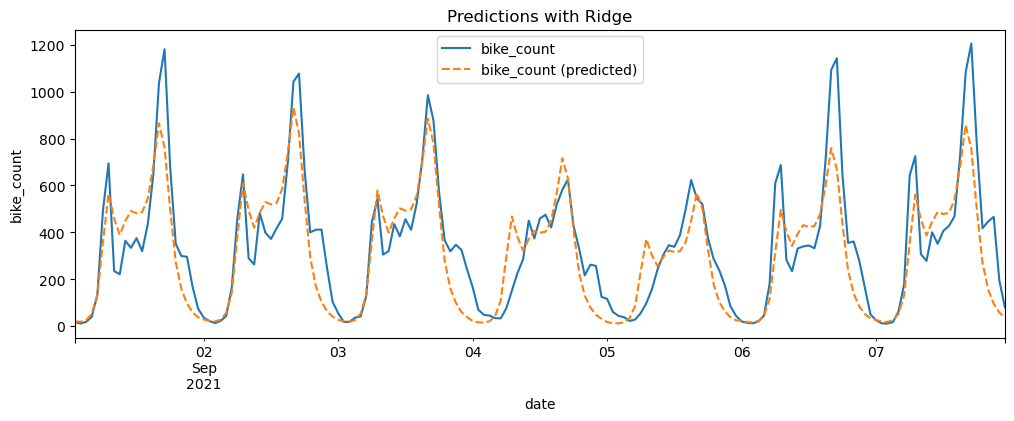

In [285]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

<Axes: xlabel='y_true', ylabel='y_pred'>

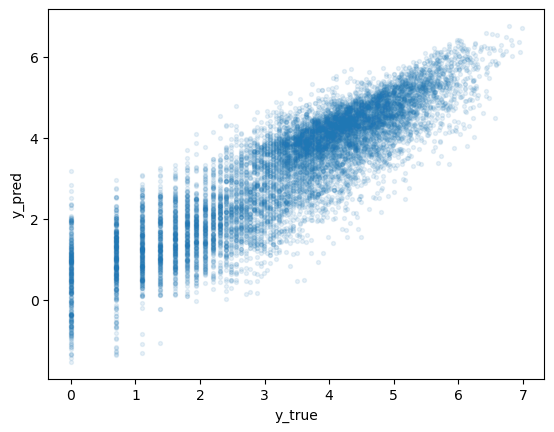

In [286]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

In [287]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370993 -0.87155645 -0.85104537 -0.87402957 -1.06387423 -0.96757061]
RMSE (all folds): 0.932 ± 0.0744


# XGBRegressor

In [288]:
def identity(x):
    return x

In [289]:
from xgboost import XGBRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

binary_cols = ["is_weekend","is_holiday","season","is_confinement","TimeOfDay","distance"]#"is_couvre_feu"]
binary_encoder = FunctionTransformer(func=identity, validate=False)

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]
#categorical_encoder_2 = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= np.nan, max_categories = 4)
#categorical_cols_2 = ["temperature"]
standard_scaler = StandardScaler()
#poly_fit = PolynomialFeatures(degree=3)
continuous_var = ["log_rain"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("bin", binary_encoder, binary_cols),
        #("cat2", categorical_encoder_2, categorical_cols_2)
        ("con", standard_scaler, continuous_var)
        #"continuous", poly_fit, continuous_var)
    ]
)

regressor = XGBRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x1667972e0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('bin',
                                                  FunctionTransformer(fun...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [290]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.83549722 -0.90156759 -0.69917188 -0.77931528 -0.82802497 -0.75655068]
RMSE (all folds): 0.8 ± 0.0643


In [291]:
print(pipe.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x1667972e0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('bin',
                                                  FunctionTransformer(fun...
                              feature_types=None, gamma=None, grow_policy=None,
           

In [297]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'xgbregressor__n_estimators': [100,200,300],
    'xgbregressor__max_depth': [6,9,12],
    'xgbregressor__learning_rate': [0.08, 0.09, 1],
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object get_cv at 0x40d161d80>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x1667972e0>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.08, 0.09, 1],
                         'xgbregressor__max_depth': [6, 9, 12],
                         'xgbregressor__n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [298]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'xgbregressor__learning_rate': 0.09, 'xgbregressor__max_depth': 12, 'xgbregressor__n_estimators': 100}
Best RMSE:  0.7527695436753405


# SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = SGDRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('sgdregressor', SGDRegressor(random_state=42))])

In [ ]:
cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.85406942 -1.74773686 -1.29495917 -1.02859285 -1.16088474 -1.08124006]
RMSE (all folds): 1.19 ± 0.281


In [ ]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('sgdregressor', SGDRegressor(random_state=42))])>

In [ ]:
param_grid = {
    'sgdregressor__penalty':['l1','l2','elasticnet'],
    'sgdregressor__learning_rate':['constant','optimal','invscaling','adaptive'],
    'sgdregressor__loss':['squared_error', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive']
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object get_cv at 0x174adef80>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                          'site_name'])])),
                                       ('sgdregressor',
                                        SGDRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'sgdregressor__learning_rate': ['constant', 'optimal',
                                                         'invscaling',
                                                         'adaptive'],
                         'sgdregressor__loss': ['squared_error',
                                                'epsilon_insensitive', 'huber',
                                                'squared_epsilon_insensitive'],
                         'sgdregressor__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'sgdregressor__learning_rate': 'optimal', 'sgdregressor__loss': 'huber', 'sgdregressor__penalty': 'l2'}
Best RMSE:  1.0927280564573747


# CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor
binary_cols = ["is_weekend","is_holiday","season","is_confinement","TimeOfDay"]#"is_couvre_feu","TimeOfDay"]
binary_encoder = FunctionTransformer(func=identity, validate=False)

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]
#categorical_encoder_2 = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= np.nan, max_categories = 4)
#categorical_cols_2 = ["temperature"]
standard_scaler = StandardScaler()
#poly_fit = PolynomialFeatures(degree=3)
continuous_var = ["log_rain"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("bin", binary_encoder, binary_cols),
        #("cat2", categorical_encoder_2, categorical_cols_2)
        ("con", standard_scaler, continuous_var)
        #"continuous", poly_fit, continuous_var)
    ]
)

regressor = CatBoostRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Learning rate set to 0.107739
0:	learn: 1.5718260	total: 70.8ms	remaining: 1m 10s
1:	learn: 1.4846412	total: 83.3ms	remaining: 41.5s
2:	learn: 1.4093577	total: 94.7ms	remaining: 31.5s
3:	learn: 1.3441395	total: 111ms	remaining: 27.7s
4:	learn: 1.2871882	total: 125ms	remaining: 24.8s
5:	learn: 1.2386223	total: 137ms	remaining: 22.7s
6:	learn: 1.1960974	total: 149ms	remaining: 21.1s
7:	learn: 1.1602175	total: 160ms	remaining: 19.8s
8:	learn: 1.1298489	total: 173ms	remaining: 19s
9:	learn: 1.1031389	total: 193ms	remaining: 19.1s
10:	learn: 1.0750844	total: 212ms	remaining: 19.1s
11:	learn: 1.0541040	total: 237ms	remaining: 19.5s
12:	learn: 1.0319496	total: 251ms	remaining: 19s
13:	learn: 1.0137406	total: 263ms	remaining: 18.6s
14:	learn: 0.9970097	total: 274ms	remaining: 18s
15:	learn: 0.9824612	total: 287ms	remaining: 17.7s
16:	learn: 0.9700717	total: 300ms	remaining: 17.4s
17:	learn: 0.9572695	total: 316ms	remaining: 17.2s
18:	learn: 0.9461788	total: 336ms	remaining: 17.4s
19:	learn: 0.

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x1777d0040>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('bin',
                                                  FunctionTransformer(func=<function identity at 0x30a47cf40>),
                                                  ['is_weekend', 'is_holiday',
                                                   'season', 'is_confinement',
                                                   'TimeOfDay']),
                                                 ('con', StandardScaler(),
                                                  ['log_rain'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x177e2fe10>)])

In [ ]:
cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

Learning rate set to 0.079223
0:	learn: 1.5217004	total: 4.18ms	remaining: 4.18s
1:	learn: 1.4497193	total: 6.54ms	remaining: 3.27s
2:	learn: 1.3857268	total: 9.07ms	remaining: 3.01s
3:	learn: 1.3293164	total: 11.5ms	remaining: 2.86s
4:	learn: 1.2774041	total: 13.8ms	remaining: 2.75s
5:	learn: 1.2331098	total: 16.1ms	remaining: 2.66s
6:	learn: 1.1940628	total: 19ms	remaining: 2.69s
7:	learn: 1.1575151	total: 21.5ms	remaining: 2.66s
8:	learn: 1.1262427	total: 23.6ms	remaining: 2.6s
9:	learn: 1.0967583	total: 26.8ms	remaining: 2.65s
10:	learn: 1.0679602	total: 29.6ms	remaining: 2.66s
11:	learn: 1.0449113	total: 32ms	remaining: 2.64s
12:	learn: 1.0216987	total: 34.7ms	remaining: 2.64s
13:	learn: 1.0019256	total: 37.2ms	remaining: 2.62s
14:	learn: 0.9832258	total: 39.8ms	remaining: 2.61s
15:	learn: 0.9676017	total: 42.3ms	remaining: 2.6s
16:	learn: 0.9517957	total: 44.9ms	remaining: 2.6s
17:	learn: 0.9382017	total: 47.3ms	remaining: 2.58s
18:	learn: 0.9238974	total: 50.4ms	remaining: 2.6s


In [ ]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x157ac11c0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x29acdab90>)])>

In [ ]:
param_grid = {
    'catboostregressor__iterations': [100, 300, 500],
    'catboostregressor__depth': [6],
    'catboostregressor__learning_rate': [0.5],
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

0:	learn: 1.1251622	total: 11.4ms	remaining: 1.13s
1:	learn: 0.9477931	total: 19.5ms	remaining: 955ms
2:	learn: 0.8577721	total: 48.8ms	remaining: 1.58s
3:	learn: 0.7994477	total: 60.3ms	remaining: 1.45s
4:	learn: 0.7489322	total: 73.6ms	remaining: 1.4s
5:	learn: 0.7073473	total: 88.1ms	remaining: 1.38s
6:	learn: 0.6766785	total: 97.5ms	remaining: 1.29s
7:	learn: 0.6527918	total: 109ms	remaining: 1.25s
8:	learn: 0.6338568	total: 119ms	remaining: 1.2s
9:	learn: 0.6162392	total: 127ms	remaining: 1.14s
10:	learn: 0.5995486	total: 136ms	remaining: 1.1s
11:	learn: 0.5880654	total: 146ms	remaining: 1.07s
12:	learn: 0.5746056	total: 161ms	remaining: 1.08s
13:	learn: 0.5629220	total: 168ms	remaining: 1.03s
14:	learn: 0.5490681	total: 183ms	remaining: 1.04s
15:	learn: 0.5369264	total: 212ms	remaining: 1.11s
16:	learn: 0.5298594	total: 219ms	remaining: 1.07s
17:	learn: 0.5205584	total: 235ms	remaining: 1.07s
18:	learn: 0.5124980	total: 250ms	remaining: 1.07s
0:	learn: 1.2112432	total: 33ms	remai

GridSearchCV(cv=<generator object get_cv at 0x160e1c280>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x1777d0040>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                          'is_holiday',
                                                                          'season',
                                                                          'is_confinement',
                                                                          'TimeOfDay']),
                                                                        ('con',
                                                                         StandardScaler(),
                                                                         ['log_rain'])])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x177e2fe10>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__depth': [6],
                         'catboostregressor__iterations': [100, 300, 500],
                         'catboostregressor__learning_rate': [0.5]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'catboostregressor__depth': 6, 'catboostregressor__iterations': 300, 'catboostregressor__learning_rate': 0.5}
Best RMSE:  0.7453384774025797
